In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ML/CatVsDog/dataset-final.zip -d /content/drive/MyDrive/ML/CatVsDog/

In [ ]:
import os
print(len(os.listdir('/content/drive/MyDrive/ML/CatVsDog/dataset/train/dogs')))
print(len(os.listdir('/content/drive/MyDrive/ML/CatVsDog/dataset/train/cats')))
print(len(os.listdir('/content/drive/MyDrive/ML/CatVsDog/dataset/test/dogs')))
print(len(os.listdir('/content/drive/MyDrive/ML/CatVsDog/dataset/test/cats')))

8995
8995
1227
3505


In [ ]:
!pip install wandb
!pip install efficientnet_pytorch
!pip install timm
!pip install poutyne

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import os
import wandb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from poutyne import set_seeds, Model, ModelCheckpoint, Callback, CSVLogger

In [ ]:
#Set up WANDB
wandb.login()
wandb.init(project="CatvsDog_EfficientNetV2B2", name='Poutyne_ENv2b2_Pretrained')

## Data Augmentation and Splitting

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

set_seeds(42)

# Define paths to your training and test data directories
train_data_dir = '/content/drive/MyDrive/ML/CatVsDog/dataset/train'
test_data_dir = '/content/drive/MyDrive/ML/CatVsDog/dataset/test'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train dataset
train_dataset = ImageFolder(root=train_data_dir, transform=transform)

# Calculate the number of samples for validation
validation_size = int(0.15 * len(train_dataset))

# Split the train dataset into train and validation sets using train_test_split
train_indices, validation_indices = train_test_split(
    range(len(train_dataset)),
    test_size=validation_size,
    stratify=train_dataset.targets,  # Making sure the class distribution is preserved
    random_state=42
)


# Create Subset classes for train and validation datasets
train_subset = Subset(train_dataset, train_indices)
validation_subset = Subset(train_dataset, validation_indices)

# Define batch size and create data loaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)

# Load test dataset
test_dataset = ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset: {len(train_subset)} images belonging to {len(train_dataset.classes)} classes.")
print(f"Validation dataset: {len(validation_subset)} images belonging to {len(train_dataset.classes)} classes.")
print(f"Test dataset: {len(test_dataset)} images belonging to {len(test_dataset.classes)} classes.")


Train dataset: 15292 images belonging to 2 classes.
Validation dataset: 2698 images belonging to 2 classes.
Test dataset: 4732 images belonging to 2 classes.


## Model Definition

In [ ]:
# Check for GPU availability and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the EfficientNetV2-B2 model
e_netv2b2 = timm.create_model('tf_efficientnetv2_b2', pretrained=True)

# Modify the final fully connected layer for your specific classification task
num_classes = 2
e_netv2b2.classifier = nn.Linear(e_netv2b2.classifier.in_features, num_classes)

#freezing the network except for its head
def freeze_weights(e_netv2b2):
    for name, param in e_netv2b2.named_parameters():
        if not name.startswith('classifier.'):
            param.requires_grad = False

freeze_weights(e_netv2b2)

# Move the model to the GPU if available
e_netv2b2 = e_netv2b2.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(e_netv2b2.parameters(), lr=0.001)

# Define the Poutyne model
model = Model(e_netv2b2, optimizer, criterion, batch_metrics=['accuracy'], device=device)

## Defining callbacks

In [ ]:
# Define the directory for saving model weights to Google Drive
weight_checkpoint_dir = '/content/drive/MyDrive/ML/CatVsDog/Weights'
log_checkpoint_dir='/content/drive/MyDrive/ML/CatVsDog/Logs'

callbacks = [
   # Define the ModelCheckpoint callback for Google Drive
    ModelCheckpoint(
    os.path.join(weight_checkpoint_dir, 'PT_EfficientNetV2B2_pretrained_{epoch}.pth'),
    monitor="val_acc",
    mode="max",
    save_best_only=False,
    restore_best=False,
    verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(log_checkpoint_dir, 'log_catvsdog_poutyne_pretrained.tsv'), separator='\t'),
]

##Training and Validation

In [ ]:
history_list = model.fit_generator(train_loader, validation_loader, epochs=11, callbacks=callbacks)

#wandb code given again at the end of this notebook

# history = history_list[0]

# # Log metrics to wandb
# wandb.log({
#         "train_loss": history['loss'],
#         "train_accuracy": history['acc'],
#         "val_loss": history['val_loss'],
#         "val_accuracy": history['val_acc'],
# })

# wandb.finish()

Epoch:  1/11 Train steps: 478 Val steps: 85 4m49.78s loss: 0.258283 acc: 90.151713 val_loss: 0.189374 val_acc: 92.772424
Epoch 1: saving file to /content/drive/MyDrive/ML/CatVsDog/Weights/PT_EfficientNetV2B2_pretrained_1.pth
Epoch:  2/11 Train steps: 478 Val steps: 85 4m43.17s loss: 0.192420 acc: 92.263929 val_loss: 0.168545 val_acc: 93.476649
Epoch 2: saving file to /content/drive/MyDrive/ML/CatVsDog/Weights/PT_EfficientNetV2B2_pretrained_2.pth
Epoch:  3/11 Train steps: 478 Val steps: 85 4m32.78s loss: 0.183581 acc: 92.813236 val_loss: 0.167222 val_acc: 93.587843
Epoch 3: saving file to /content/drive/MyDrive/ML/CatVsDog/Weights/PT_EfficientNetV2B2_pretrained_3.pth
Epoch:  4/11 Train steps: 478 Val steps: 85 4m30.75s loss: 0.176981 acc: 92.911326 val_loss: 0.167038 val_acc: 93.810230
Epoch 4: saving file to /content/drive/MyDrive/ML/CatVsDog/Weights/PT_EfficientNetV2B2_pretrained_4.pth
Epoch:  5/11 Train steps: 478 Val steps: 85 4m33.72s loss: 0.169819 acc: 93.081350 val_loss: 0.15880

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,90.15171
train_loss,0.25828
val_accuracy,92.77242
val_loss,0.18937


In [ ]:
#we can also see the logs from saved logs
import pandas as pd
logs = pd.read_csv(os.path.join(log_checkpoint_dir, 'log_catvsdog_poutyne_pretrained.tsv'), sep='\t')
print(logs)

    epoch        time     lr      loss        acc  val_loss    val_acc
0       1  289.782159  0.001  0.258283  90.151713  0.189374  92.772424
1       2  283.167502  0.001  0.192420  92.263929  0.168545  93.476649
2       3  272.776306  0.001  0.183581  92.813236  0.167222  93.587843
3       4  270.754236  0.001  0.176981  92.911326  0.167038  93.810230
4       5  273.720486  0.001  0.169819  93.081350  0.158801  93.810230
5       6  275.979370  0.001  0.164824  93.290609  0.151196  93.921423
6       7  272.519524  0.001  0.170386  92.970180  0.142311  94.477391
7       8  274.415957  0.001  0.167663  93.375621  0.147237  94.069681
8       9  268.873790  0.001  0.167057  93.251373  0.158113  93.921423
9      10  273.549391  0.001  0.167998  93.231755  0.151961  93.773165
10     11  274.397734  0.001  0.162471  93.316767  0.155797  93.921423


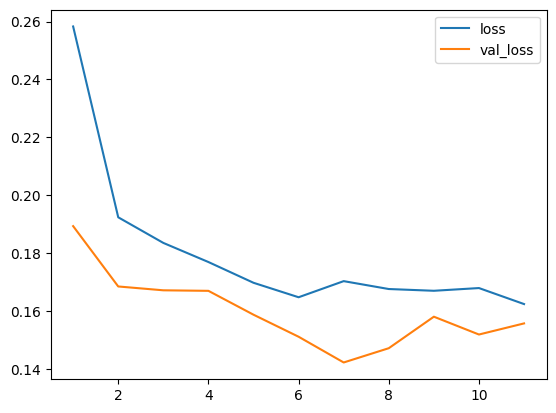

In [ ]:
#plotting training and validation loss
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

In [ ]:
#finding best epoch
best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

Best epoch: 7


## Evaluating the model on test set

In [ ]:
#loading best saved weight to the model
model = Model(e_netv2b2, optimizer, criterion, batch_metrics=['accuracy'], device=device)
model.load_weights('/content/drive/MyDrive/ML/CatVsDog/Weights/PT_EfficientNetV2B2_pretrained_7.pth')

test_loss, test_acc,  = model.evaluate_generator(test_loader)

Test steps: 148 1m11.05s test_loss: 0.178094 test_acc: 92.899408                              


Classification Report:
              precision    recall  f1-score   support

        cats       0.97      0.94      0.96      3505
        dogs       0.84      0.93      0.88      1227

    accuracy                           0.94      4732
   macro avg       0.91      0.93      0.92      4732
weighted avg       0.94      0.94      0.94      4732



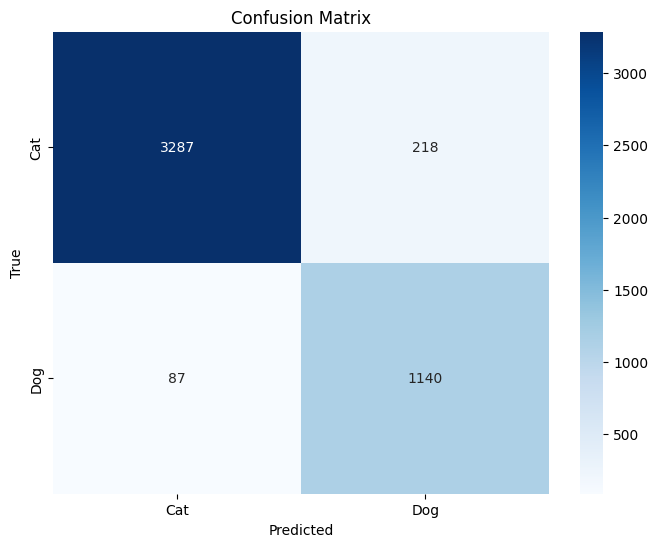

In [ ]:
# Calculate classification report and plot confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model.predict_on_batch(inputs)  # Use predict_on_batch to get predictions
        predicted = np.argmax(outputs, axis=1)  # Get the class with the highest probability
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted)

class_names = test_dataset.classes

#Printing Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#Plotting Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Logging history value in wandb again
I did mistake previously in the code while logging history value in wandb. But I saved the history_list before run time disconnects. That saves me from running entire training loop again. Here i load the history_list variable as loaded_history_list.

In [ ]:
#for saving history_list
# import csv

# # Save the history_list to a CSV file
# csv_file_path = '/content/drive/MyDrive/Logs/history_list.csv'

# with open(csv_file_path, mode='w', newline='') as file:
#     fieldnames = history_list[0].keys()
#     writer = csv.DictWriter(file, fieldnames=fieldnames)
#     writer.writeheader()
#     writer.writerows(history_list)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv

csv_file_path = '/content/drive/MyDrive/ML/CatVsDog/pretrained_history_list.csv'

# Initialize an empty list to store the loaded history
loaded_history_list = []

# Read the CSV file and load the data into the list
with open(csv_file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        loaded_history_list.append(row)

loaded_history_list


In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: rifat004. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="CatvsDog_EfficientNetV2B2", name='Poutyne_Pretrained_run2',
           config={
    "learning_rate": 0.01,
    "epochs": 11,
    })


In [ ]:
# Iterate through the loaded history and log metrics
for epoch_info in loaded_history_list:
    epoch = int(epoch_info['epoch'])
    train_loss = float(epoch_info['loss'])
    train_accuracy = float(epoch_info['acc'])
    val_loss = float(epoch_info['val_loss'])
    val_accuracy = float(epoch_info['val_acc'])

    # Log metrics to WandB for each epoch
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_acc': train_accuracy,
        'val_loss': val_loss,
        'val_acc': val_accuracy
    })

# Finish the WandB run
wandb.finish()

epoch,▁▂▂▃▄▅▅▆▇▇█
train_acc,▁▆▇▇▇█▇████
train_loss,█▃▃▂▂▁▂▁▁▁▁
val_acc,▁▄▄▅▅▆█▆▆▅▆
val_loss,█▅▅▅▃▂▁▂▃▂▃
epoch,11
train_acc,93.31677
train_loss,0.16247
val_acc,93.92142
val_loss,0.1558
